In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import random
import time
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import pyro
from IPython.display import HTML

import collab2.foraging.toolkit as ft
from collab2.foraging import random_hungry_followers as rhf
from collab2.foraging.toolkit import animate_predictors, plot_predictor
from collab2.utils import find_repo_root

logging.basicConfig(format="%(message)s", level=logging.INFO)

root = find_repo_root()

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
# smoke_test = True
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

notebook_starts = time.time()

In [2]:
# load the data
path = os.path.join(
    root,
    # "data/foraging/gerbils/2020_08_01_18_10_16_589437_compressed_Day_spine (1).npy",
    "data/foraging/gerbils/2020_07_23_18_29_24_027132_compressed_Day_spine.npy",
)
data = np.load(path)

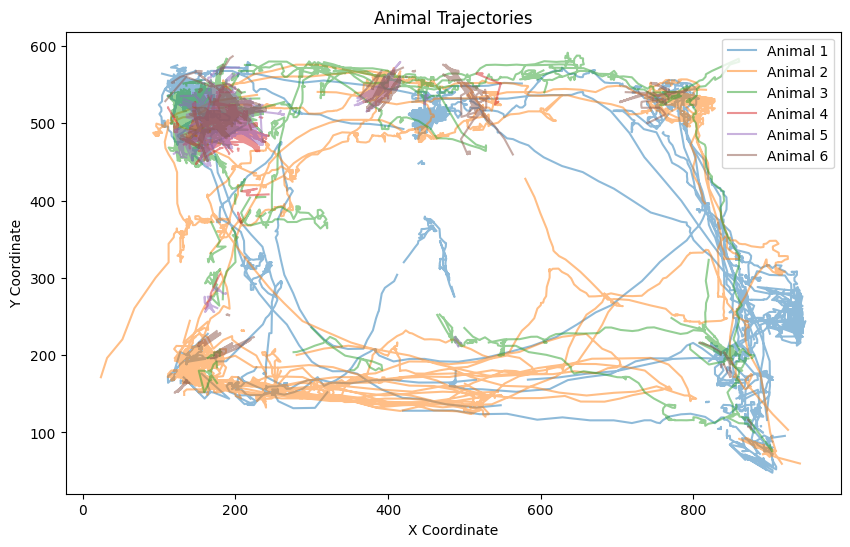

In [3]:
# plot the data
# the dimensions of the data are (time, animal_num, XY)

#  data shape is (time, animal_num, XY)

time_steps, animal_num, _ = data.shape

# Create a plot for each animal's trajectory
plt.figure(figsize=(10, 6))

for i in range(animal_num):
    # Extract the X and Y coordinates for the current animal
    x_coords = data[:, i, 0]
    y_coords = data[:, i, 1]

    # Plot the trajectory
    plt.plot(x_coords, y_coords, label=f"Animal {i+1}", alpha=0.5)

# Add labels and a legend
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Animal Trajectories")
plt.legend()

# Show the plot
plt.show()

In [4]:
# Format the data in dataframes as expected for further analysis

# make a dataframe with columns for x, y, time, forager (animal_num), and type (always gerbil)
# Initialize lists to hold the data for the dataframe
time_list = []
forager_list = []
x_list = []
y_list = []
type_list = []

Tmax = 1000 # use only beginning of data for now

# Populate the lists with the data
for timei in range(Tmax):
    for forager in range(animal_num):
        x_list.append(data[timei, forager, 0])
        y_list.append(data[timei, forager, 1])
        time_list.append(timei)
        forager_list.append(forager)
        type_list.append("gerbil")

# Create the dataframe
gerbil_df = pd.DataFrame(
    {
        "time": time_list,
        "forager": forager_list,
        "x": x_list,
        "y": y_list,
        "type": type_list,
    }
)


# Define the range and location for rewards
x_range = range(250, 651)  # x locations from 250 to 650
y_location = 700  # y location fixed at 700

# Use numpy to efficiently create arrays for the rewards DataFrame
x_array = np.tile(np.arange(250, 651), time_steps)
y_array = np.full(x_array.shape, y_location)
time_array = np.repeat(np.arange(time_steps), len(x_range))

# Create the rewards DataFrame
rewardsDF = pd.DataFrame({"x": x_array, "y": y_array, "time": time_array})

# # Remove times where any value in gerbil_df is NaN
# nan_times = gerbil_df[gerbil_df.isna().any(axis=1)]["time"]

# # Filter gerbil_df to exclude rows with these times
# gerbil_df_clean = gerbil_df[~gerbil_df["time"].isin(nan_times)]

# # Filter rewardsDF to exclude rows with these times
# rewardsDF_clean = rewardsDF[~rewardsDF["time"].isin(nan_times)]

# # Display the cleaned DataFrames
# print(gerbil_df_clean.head())
# print(gerbil_df_clean["time"].unique().shape)
# print(rewardsDF_clean.head())

# # restrict to time range
# gerbil_df_clean = gerbil_df_clean[
#     (gerbil_df_clean["time"] >= tmin) & (gerbil_df_clean["time"] <= tmax)
# ]
# rewardsDF_clean = rewardsDF_clean[
#     (rewardsDF_clean["time"] >= tmin) & (rewardsDF_clean["time"] <= tmax)
# ]

forager_object = ft.utils.dataObject(
    gerbil_df,
    grid_size=1000,
    rewardsDF=rewardsDF,
)

/Users/emily/code/collaborative-intelligence/collab2/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(


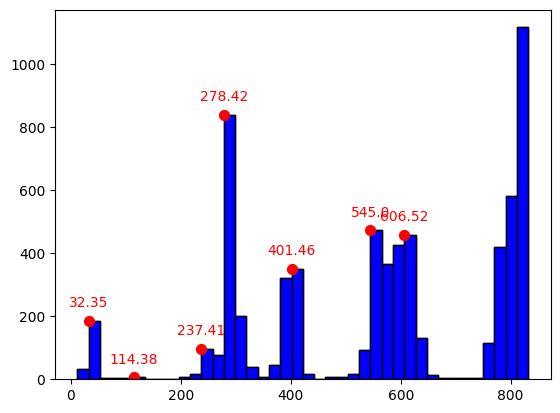

In [7]:
forager_distances = ft.foragers_to_forager_distances(forager_object)
ft.distances_and_peaks(forager_distances)

In [8]:
local_windows_kwargs = {
    "window_size": 100,
    "sampling_fraction": .1, 
    "skip_incomplete_frames": False,
}

predictor_kwargs = {
    "proximity_40": {
        "interaction_length": 100,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 40,
        "proximity_decay": 1,
    },
    "proximity_100": {
        "interaction_length": 100,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 100,
        "proximity_decay": 1,
    },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF = ft.derive_predictors_and_scores(
    forager_object,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

display(derivedDF)

2024-09-26 23:28:25,983 - proximity_40 completed in 3.53 seconds.
2024-09-26 23:28:29,288 - proximity_100 completed in 3.31 seconds.


TypeError: 'NoneType' object does not support item assignment

In [ ]:
plot_predictor(
    forager_object.foragers,
    forager_object.derived_quantities["proximity"],
    predictor_name="proximity",
    time=range(min(8, num_frames)),
    grid_size=1000,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=[0, 1, 2, 3, 4, 5],
    forager_predictor_indices=[1],
)